# 동사무소 -> 집
---
1. 트럭
    - 속도: 30km/h
    - 대기 시간: 3m
    - osrm을 통한 경로 추출
2. 로봇
    - 여러 대 배치
    - 속도: 5.76km/h
    - ortools로 각 로봇마다의 경로 추출?(지나가는 집들 정해주기) 
    - 경로를 추출 했으면 osrm으로 경로 시각화

- 트럭과 로봇 전체 이용 가능한 OD 데이터 생성    
    - O: 동사무소 지점, D: 각 집들 지점


# 기본 데이터프레임

동사무소를 시작으로 배달해야하는 집들을 모은 데이터

- O: 행운동 주민센터
    37.480612, 126.957058

- D: 집들
    37.48244, 126.9599   
    37.482910, 126.960263   
    37.482598, 126.960670   
    37.482090, 126.961705   
    37.481065, 126.960866   
    37.481641, 126.962215   
    37.480656, 126.960684  
    37.481865, 126.960223  
    37.482193, 126.960798  
    37.483107, 126.959768  
    37.483176, 126.959367  
    37.482719, 126.958830  
    37.482362, 126.958735  
    37.482177, 126.959455  
    37.481477, 126.958312  
    37.479437, 126.960847  
    37.480370, 126.963237  

In [40]:
import pandas as pd
import numpy as np
from shapely.geometry import Point

In [5]:
# 변수 설정

## O 데이터 (행운동 주민센터)
O = ['행운동 주민센터'] * 17
O_point = [[126.957058, 37.480612]] * 17  # 좌표 (longitude, latitude)
O_time = [600] * 17  # 시간 데이터

## D 데이터
D = [
    'home1', 'home2', 'home3', 'home4', 'home5', 'home6', 'home7', 'home8', 'home9', 'home10',
    'home11', 'home12', 'home13', 'home14', 'home15', 'home16', 'home17'
]
D_point = [
    [126.9599, 37.48244],
    [126.960263, 37.482910],
    [126.960670, 37.482598],
    [126.961705, 37.482090],
    [126.960866, 37.481065],
    [126.962215, 37.481641],
    [126.960684, 37.480656],
    [126.960223, 37.481865],
    [126.960798, 37.482193],
    [126.959768, 37.483107],
    [126.959367, 37.483176],
    [126.958830, 37.482719],
    [126.958735, 37.482362],
    [126.959455, 37.482177],
    [126.958312, 37.481477],
    [126.960847, 37.479437],
    [126.963237, 37.480370]
]

# 좌표를 WKT 형식으로 변환
O_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in O_point]
D_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in D_point]

# 데이터프레임 구성
OD_data = pd.DataFrame({
    'O': O,
    'O_point': O_point_wkt,
    'O_time': O_time,
    'D': D,
    'D_point': D_point_wkt
})

# 문자열을 Point 객체로 변환하는 함수
def convert_to_point(point_str):
    # 'POINT (127.127384 37.45091)' -> [127.127384, 37.45091]
    coords = point_str.replace("POINT (", "").replace(")", "").split()
    return Point(float(coords[0]), float(coords[1]))

# 'start_point'와 'end_point'를 Point 객체로 변환
OD_data['O_point'] = OD_data['O_point'].apply(convert_to_point)
OD_data['D_point'] = OD_data['D_point'].apply(convert_to_point)

In [6]:
OD_data

,O,O_point,O_time,D,D_point
0,행운동 주민센터,POINT (126.957058 37.480612),600,home1,POINT (126.9599 37.48244)
1,행운동 주민센터,POINT (126.957058 37.480612),600,home2,POINT (126.960263 37.48291)
2,행운동 주민센터,POINT (126.957058 37.480612),600,home3,POINT (126.96067 37.482598)
3,행운동 주민센터,POINT (126.957058 37.480612),600,home4,POINT (126.961705 37.48209)
4,행운동 주민센터,POINT (126.957058 37.480612),600,home5,POINT (126.960866 37.481065)
5,행운동 주민센터,POINT (126.957058 37.480612),600,home6,POINT (126.962215 37.481641)
6,행운동 주민센터,POINT (126.957058 37.480612),600,home7,POINT (126.960684 37.480656)
7,행운동 주민센터,POINT (126.957058 37.480612),600,home8,POINT (126.960223 37.481865)
8,행운동 주민센터,POINT (126.957058 37.480612),600,home9,POINT (126.960798 37.482193)
9,행운동 주민센터,POINT (126.957058 37.480612),600,home10,POINT (126.959768 37.483107)


In [8]:
# csv파일로 저장
OD_data.to_csv('../data/행운동-OD_data.csv', index=False)

# 트럭

트럭 데이터프레임 구성
- O: 동사무소 지점
- D: 각 집들의 지점
- 속도: 30km/h(골목이므로 어린이 보호구역을 기준으로 가정)
- 대기 시간(기사가 내려서 배달하는 시간): 3min으로 가정
- 출발 시간: 출발 시간을 설정해서 최종 duration 계산, 시각화에 사용
- 도착 시간: 거리와 속도 계산을 통해 최종 출발 시간 + duration으로 구하기
- duration: 총 걸린 시간(이동 시간 + 대기 시간)
- distance: 총 걸린 거리

In [10]:
# 트럭 데이터프레임 구성하기

# 변수 설정하기
## 트럭 데이터
speed = [30] * 17
wait_time = [0] * 17
arrive_time = [0] * 17
duration = [0] * 17
distance = [0] * 17

# 데이터프레임 구성하기
OD_data_truck = OD_data.copy()
OD_data_truck['speed(km/h)'] = speed
OD_data_truck['wait_time'] = wait_time
OD_data_truck['arrive_time'] = arrive_time
OD_data_truck['duration'] = duration
OD_data_truck['distance(단위)'] = distance

In [11]:
OD_data_truck

,O,O_point,O_time,D,D_point,speed(km/h),wait_time,arrive_time,duration,distance(단위)
0,행운동 주민센터,POINT (126.957058 37.480612),600,home1,POINT (126.9599 37.48244),30,0,0,0,0
1,행운동 주민센터,POINT (126.957058 37.480612),600,home2,POINT (126.960263 37.48291),30,0,0,0,0
2,행운동 주민센터,POINT (126.957058 37.480612),600,home3,POINT (126.96067 37.482598),30,0,0,0,0
3,행운동 주민센터,POINT (126.957058 37.480612),600,home4,POINT (126.961705 37.48209),30,0,0,0,0
4,행운동 주민센터,POINT (126.957058 37.480612),600,home5,POINT (126.960866 37.481065),30,0,0,0,0
5,행운동 주민센터,POINT (126.957058 37.480612),600,home6,POINT (126.962215 37.481641),30,0,0,0,0
6,행운동 주민센터,POINT (126.957058 37.480612),600,home7,POINT (126.960684 37.480656),30,0,0,0,0
7,행운동 주민센터,POINT (126.957058 37.480612),600,home8,POINT (126.960223 37.481865),30,0,0,0,0
8,행운동 주민센터,POINT (126.957058 37.480612),600,home9,POINT (126.960798 37.482193),30,0,0,0,0
9,행운동 주민센터,POINT (126.957058 37.480612),600,home10,POINT (126.959768 37.483107),30,0,0,0,0


In [12]:
# 라이브러리 불러오기
import numpy as np
import itertools
import requests
import polyline
import json
import os
import math

import random as rd
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

In [13]:
# 좌표 거리 생성 함수
## 직선 거리 계산 함수
## 거리 계산할 때 경로를 모르는 경우 사용
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    '''
    좌표 거리 생성 함수 
    - 직선 거리 계산 
    - 경로를 모르는 경우 두 지점 간의 대략적인 직선 거리를 계산할 때 사용

    입력값:
        lat1: 출발지 위도 (float)
        lon1: 출발지 경도 (float)
        lat2: 도착지 위도 (float)
        lon2: 도착지 경도 (float)

    출력값:
        두 지점 간의 직선 거리 (킬로미터 단위, float)
    '''
# 직선 거리 계산
# 입력값: 출발지 위도, 경도 / 도착지 위도, 경도
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 # 도착지 위도 - 출발지 위도
    dlon = lon2 - lon1 # 도착지 경도 - 출발지 경도

    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (킬로미터 단위)
    km = km_constant * c
    
    return km # 출발지-도착지 사이의 직선 거리 반환

In [14]:
# trips 데이터 생성 함수
#### osrm 페키지로 경로 추출
# 입력으로 받은 출발지와 목적지 좌표를 이용하여 경로 정보를 가져오는 함수
def get_res(point, mode = 'foot'): # 도보 이용

   # point: 출발지와 목적지 좌표 정보를 포함하는 리스트[lat1, lon1, lat2, lon2]
   # mode: 이동 수단 (기본값: 도보)

   status = 'defined'

   # 요청을 재시도할 수 있도록 세션 객체 생성 및 설정
   session = requests.Session()
   retry = Retry(connect=3, backoff_factor=0.5)
   adapter = HTTPAdapter(max_retries=retry)
   session.mount('http://', adapter)
   session.mount('https://', adapter)

   #### url 생성 코드
   # 전체 경로 정보를 요청
   overview = '?overview=full'
   # lon, lat, lon, lat 형식의 출발지 목적지 좌표
   loc = f"{point[0]},{point[1]};{point[2]},{point[3]}"
   # 보행경로 url
   url = f'http://router.project-osrm.org/route/v1/{mode}/'
   # 경로 정보 요청
   r = session.get(url + loc + overview) 
   
   # 만약 경로가 안뜰 때 대체 결과 생성
   ## 직선 거리 구하기
   if r.status_code!= 200:
      
      status = 'undefined'
      
       # 직선 거리 계산
      distance = calculate_straight_distance(point[1], point[0], point[3], point[2]) * 1000
      
      # 경로 정보 생성 (출발지와 목적지 좌표만 포함)
      route = [[point[0], point[1]], [point[2], point[3]]]

      # 소요 시간 및 타임스탬프 계산 (가정: 보행 속도 10km/h)
      speed_km = 5#km
      speed = (speed_km * 1000/60)      
      duration = distance/speed
      
      timestamp = [0, duration]

      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
   
      return result, status
   
   # 경로 정보를 성공적으로 가져온 경우, JSON 응답을 반환
   res = r.json()   
   return res, status

In [15]:
# 경로를 가는데 걸리는 시간과 거리 추출 함수
def extract_duration_distance(res, speed_kmh):
   # get_res함수에서 추출된 데이터에서 시간과 거리 뽑기
   # 입력값: res(get_res함수에서 추출된 데이터), 속도 (km/h)
   
   distance = res['routes'][0]['distance']
   # JSON 응답에서 첫 번째 경로의 거리 값을 추출
   # m 단위로 거리 추출
   # duration = res['routes'][0]['duration']/(60)  # 분 단위로 변환
   
   # 속도로 시간 계산
   speed_kmh = speed_kmh  # km/h
   speed_mps = speed_kmh * 1000 / 3600  # 속도를 m/s로 변환
   duration = distance / speed_mps / 60  # 분 단위로 변환
   
   return duration, distance # 소요 시간, 거리 반환

# 경로 추출 함수
def extract_route(res):
    # 입력값: res(get_res함수에서 추출된 데이터)
   
    # get_res함수에서 추출된 데이터에서 경로 뽑기
    # 경로가 인코딩 되어 있기 때문에 아래 함수를 써서 디코딩해주어야지 위경도로 이루어진 경로가 나옴
    route = polyline.decode(res['routes'][0]['geometry'])
    
    # 사용할 형식에 맞춰 위경도 좌표의 위치를 바꿔주는 것
    route = list(map(lambda data: [data[1],data[0]] ,route))
    # data: [위도, 경도] 형식의 좌표 쌍 -> [경도, 위도] 형식의 좌표 쌍

    return route # [[127.0, 37.0], [127.1, 37.1], ...] 형식의 경로 반환

In [16]:
# 총 걸리는 시간을 경로의 거리 기준으로 쪼개주는 함수
def extract_timestamp(route, duration):
    '''
    경로의 각 구간 거리 비율에 따라 예상 도착 시간을 계산하는 함수

    입력값:
        route: 경로 정보 (위도와 경도로 구성된 리스트)
        duration: 총 소요 시간 (분 단위, float)
    
    출력값:
        timestamp: 각 지점의 예상 도착 시간 리스트 (분 단위)
    '''
    # 입력값: route(경로 정보), duration(총 소요 시간)
    
    # 리스트를 numpy이 배열로 변경
    rt = np.array(route)
    # 리스트를 수평 기준으로 합치기
    rt = np.hstack([rt[:-1,:], rt[1:,:]])
    # [출발점_lat, 출발점_lon, 도착점_lat, 도착점_lon] 형식으로 변환

    # 각각 직선거리 추출(리스트 형태)
    per = calculate_straight_distance(rt[:,1], rt[:,0], rt[:,3], rt[:,2])
    # 출발점 경도, 출발점 위도, 도착점 경도, 도착점 위도를 이용하여 직선거리 계산

    # 각각의 직선거리를 전체 직선거리의 합으로 나누기
    per = per / np.sum(per)
    # 각 구간의 직선 거리 비율 계산
    # 전체 경로에서 해당 구간이 차지하는 비율 계산

    # 계산된 비율을 기반으로 각 지점 도착 예상 시간 계산
    timestamp = per * duration
    ## 각 구간의 비율에 전체 소요 시간을 곱해 각 구간의 소요 시간 계산
    
    # 각 구간의 소요 시간을 누적하여 더하기
    timestamp = np.hstack([np.array([0]),timestamp])

    # 타임스탬프 배열의 누적 합을 계산하여 각 지점의 예상 도착 시간을 생성
    timestamp = list(itertools.accumulate(timestamp)) 
    
    return timestamp # 각 지점의 예상 도착 시간 리스트 e.g. [0, 10, 20, 30, ...] 반환

In [17]:
from functools import partial

# 모든 함수를 한번에 실행하는 코드(trips 데이터의 형태로 저장)
def osrm_routing_machine(O, D, mode, speed_kmh):
   # 입력값: 출발지 좌표, 목적지 좌표, 이동 수단, 속도

   # osrm 데이터 생성
   osrm_base, status = get_res([O.x, O.y, D.x, D.y], mode)
   
   # osrm 데이터가 생성 됬으면 진행
   if status == 'defined':
      # 거리 및 걸리는 시간 추출
      duration, distance = extract_duration_distance(osrm_base, speed_kmh)
      # 경로 추출
      route = extract_route(osrm_base)
      # timestamp 생성
      timestamp = extract_timestamp(route, duration)
      # 결과 저장
      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
      
      return result
   else: 
      return osrm_base # 경로 데이터 없을 때는 직선거리 데이터 반환
   
# OD_data 한쌍일 때 osrm_routing_machine작동함수
def osrm_routing_machine_multiprocess(OD, mode, speed_kmh):
   O, D = OD
   result = osrm_routing_machine(O, D, mode, speed_kmh)
   return result
# OD_data 데이터가 리스트쌍 일때의 osrm_routing_machine 작동함수
def osrm_routing_machine_multiprocess_all(OD_data, mode, speed_kmh):
    results = list(map(partial(osrm_routing_machine_multiprocess, mode = mode, speed_kmh=speed_kmh), OD_data))
    return results

In [18]:
# 출발시간 기반으로 탑승시간 계산 함수
def calculate_boarding_time(start_times):
    '''
    출발시간을 기반으로 탑승 시간을 계산하는 함수
    - 버스는 10분 간격으로 출발한다고 가정

    입력값:
        start_times: 출발 시간 리스트 (분 단위)

    출력값:
        boarding_times: 각 출발 시간에 대응하는 탑승 시간 리스트 (분 단위)
    '''
    boarding_times = []
    for start_time in start_times:
        # 버스는 10분 간격으로 출발한다고 가정
        boarding_time = math.ceil(start_time / 10) * 10
        boarding_times.append(boarding_time)
    return boarding_times

# 데이터프레임에서 OD 데이터와 출발시간, 탑승시간 데이터 추출 함수
def extract_od_and_start_time(df):
    '''
    데이터프레임에서 OD 데이터와 출발 시간, 탑승 시간 데이터를 추출하는 함수

    입력값:
        df: OD 데이터가 포함된 데이터프레임
            - 컬럼: start_point (출발지 위경도), end_point (도착지 위경도), start_time, boarding_time

    출력값:
        od_data: OD 데이터 리스트 ([[출발지 위경도, 도착지 위경도], ...])
        start_time: 출발 시간 리스트
        boarding_time: 탑승 시간 리스트
    '''
    # OD 데이터를 추출 (출발점과 도착점의 위경도)
    od_data = [[row['start_point'], row['end_point']] for _, row in df.iterrows()]
    
    # 출발시간과 탑승시간 데이터를 리스트로 추출
    start_time = df['start_time'].tolist()
    boarding_time = df['boarding_time'].tolist()
    
    return od_data, start_time, boarding_time

In [22]:
# 경로 생성 함수들: get_res, extract_duration_distance, extract_route, extract_timestamp 사용
# 그 외 보조 함수들: calculate_straight_distance, calculate_boarding_time, osrm_routing_machine 등 사용

def calculate_route_with_stops(start_point, stops, mode, speed_kmh, wait_time=3):
    """
    OSRM을 사용해 시작 지점에서 특정 정류장들을 거쳐 다시 시작 지점으로 돌아오는 경로를 계산.

    Args:
        start_point (Point): 시작 지점 (Shapely Point 객체)
        stops (list): 방문해야 할 정류장 리스트 (Shapely Point 객체 리스트)
        mode (str): 이동 모드 (e.g., 'car', 'foot', 'bike')
        speed_kmh (float): 차량 속도 (km/h)
        wait_time (int): 각 정류장에서 대기 시간 (분 단위)

    Returns:
        dict: 경로, 시간, 거리 정보가 포함된 딕셔너리
    """
    # 경로 계산 결과 초기화
    total_route = []
    total_duration = 0
    total_distance = 0
    timestamps = []

    # 경유지를 포함한 순환 경로: 시작 지점 -> 각 정류장 -> 시작 지점
    all_points = [start_point] + stops + [start_point]

    # 각 구간에 대해 경로 계산
    for i in range(len(all_points) - 1):
        O, D = all_points[i], all_points[i + 1]
        
        # OSRM 경로 계산
        result = osrm_routing_machine(O, D, mode, speed_kmh)
        segment_route = result['route']
        segment_duration = result['duration']
        segment_distance = result['distance']
        
        # 경로, 시간, 거리 누적
        total_route.extend(segment_route[:-1])  # 마지막 점은 중복 방지
        total_duration += segment_duration
        total_distance += segment_distance

        # 대기 시간 추가 (정류장에서만)
        if i > 0 and i < len(all_points) - 2:  # 중간 정류장
            total_duration += wait_time

        # 타임스탬프 갱신
        timestamps.append(total_duration)

    # 최종 경로의 마지막 지점 추가
    total_route.append(segment_route[-1])

    # 결과 반환
    return {
        "route": total_route,
        "timestamps": timestamps,
        "total_duration": total_duration,
        "total_distance": total_distance,
    }

# 예시 데이터
start = OD_data_truck["O_point"][0]  # 시작 지점
stops = [
    OD_data_truck["D_point"][0],  # 첫 번째 정류장
    OD_data_truck["D_point"][1],  # 두 번째 정류장
    OD_data_truck["D_point"][2],  # 세 번째 정류장
    OD_data_truck["D_point"][3],  # 네 번째 정류장
    OD_data_truck["D_point"][4],  # 다섯 번째 정류장
    OD_data_truck["D_point"][5],  # 여섯 번째 정류장
    OD_data_truck["D_point"][6],  # 일곱 번째 정류장
    OD_data_truck["D_point"][7],  # 여덟 번째 정류장
    OD_data_truck["D_point"][8],  # 아홉 번째 정류장
    OD_data_truck["D_point"][9],  # 열 번째 정류장
    OD_data_truck["D_point"][10],  # 열한 번째 정류장
    OD_data_truck["D_point"][11],  # 열두 번째 정류장
    OD_data_truck["D_point"][12],  # 열세 번째 정류장
    OD_data_truck["D_point"][13],  # 열네 번째 정류장
    OD_data_truck["D_point"][14],  # 열다섯 번째 정류장
    OD_data_truck["D_point"][15],  # 열여섯 번째 정류장
    OD_data_truck["D_point"][16],  # 열일곱 번째 정류장
]

# 경로 생성 실행
mode = 'car'  # 차량 이동
speed_kmh = 30  # 차량 속도 (km/h)
wait_time = 3  # 정류장 대기 시간 (분 단위)

result = calculate_route_with_stops(start, stops, mode, speed_kmh, wait_time)

# 결과 출력
print("Route:", result["route"])
print("Timestamps:", result["timestamps"])
print("Total Duration (min):", result["total_duration"])
print("Total Distance (m):", result["total_distance"])


Route: [[126.95718, 37.48066], [126.95713, 37.48073], [126.95733, 37.48085], [126.95748, 37.48099], [126.95765, 37.4809], [126.95802, 37.4813], [126.9583, 37.48122], [126.95832, 37.48126], [126.95848, 37.48153], [126.9586, 37.4815], [126.9586, 37.48152], [126.95901, 37.48193], [126.9596, 37.48251], [126.95983, 37.48237], [126.9596, 37.48251], [126.96009, 37.483], [126.96025, 37.4829], [126.96046, 37.48278], [126.9607, 37.48263], [126.9608, 37.48257], [126.96114, 37.48236], [126.9615, 37.48214], [126.96166, 37.48204], [126.96183, 37.48194], [126.96132, 37.48143], [126.96095, 37.48102], [126.96132, 37.48143], [126.96183, 37.48194], [126.96215, 37.48175], [126.96226, 37.48169], [126.96215, 37.48175], [126.96183, 37.48194], [126.96132, 37.48143], [126.96077, 37.48083], [126.96063, 37.48069], [126.96077, 37.48083], [126.96042, 37.48105], [126.96005, 37.48128], [126.95972, 37.48149], [126.96014, 37.48192], [126.96031, 37.48208], [126.96065, 37.48187], [126.9609, 37.48213], [126.96114, 37.482

In [23]:
result

{'route': [[126.95718, 37.48066],
  [126.95713, 37.48073],
  [126.95733, 37.48085],
  [126.95748, 37.48099],
  [126.95765, 37.4809],
  [126.95802, 37.4813],
  [126.9583, 37.48122],
  [126.95832, 37.48126],
  [126.95848, 37.48153],
  [126.9586, 37.4815],
  [126.9586, 37.48152],
  [126.95901, 37.48193],
  [126.9596, 37.48251],
  [126.95983, 37.48237],
  [126.9596, 37.48251],
  [126.96009, 37.483],
  [126.96025, 37.4829],
  [126.96046, 37.48278],
  [126.9607, 37.48263],
  [126.9608, 37.48257],
  [126.96114, 37.48236],
  [126.9615, 37.48214],
  [126.96166, 37.48204],
  [126.96183, 37.48194],
  [126.96132, 37.48143],
  [126.96095, 37.48102],
  [126.96132, 37.48143],
  [126.96183, 37.48194],
  [126.96215, 37.48175],
  [126.96226, 37.48169],
  [126.96215, 37.48175],
  [126.96183, 37.48194],
  [126.96132, 37.48143],
  [126.96077, 37.48083],
  [126.96063, 37.48069],
  [126.96077, 37.48083],
  [126.96042, 37.48105],
  [126.96005, 37.48128],
  [126.95972, 37.48149],
  [126.96014, 37.48192],
  [12

In [24]:
import folium

def visualize_route_with_lines(result, start_point, stops):
    """
    OSRM 경로 데이터를 folium으로 시각화하고 경로를 선으로 표현하는 함수.

    Args:
        result (dict): OSRM 경로 계산 결과
        start_point (Point): 시작 지점 (Shapely Point 객체)
        stops (list): 방문해야 할 정류장 리스트 (Shapely Point 객체 리스트)
    """
    # 지도 초기화 (시작 지점을 중심으로 설정)
    m = folium.Map(location=[start_point.y, start_point.x], zoom_start=15)

    # 경로를 선으로 추가
    if result["route"]:
        # 경로 좌표를 [latitude, longitude] 형식으로 변환
        route_latlon = [[coord[1], coord[0]] for coord in result["route"]]
        folium.PolyLine(
            locations=route_latlon,  # 변환된 경로 좌표 리스트
            color="blue",
            weight=5,
            opacity=0.7,
            tooltip=f"Total Distance: {result['total_distance']:.2f} m, Total Duration: {result['total_duration']:.2f} min"
        ).add_to(m)

    # 시작 지점 표시
    folium.Marker(
        [start_point.y, start_point.x],
        icon=folium.Icon(color="green"),
        tooltip="Start Point"
    ).add_to(m)

    # 정류장 표시
    for i, stop in enumerate(stops, start=1):
        folium.Marker(
            [stop.y, stop.x],
            icon=folium.Icon(color="red", icon="info-sign"),
            tooltip=f"Stop {i}"
        ).add_to(m)

    # 마지막 지점 표시 (돌아온 시작 지점)
    folium.Marker(
        [start_point.y, start_point.x],
        icon=folium.Icon(color="blue", icon="flag"),
        tooltip="End Point"
    ).add_to(m)

    # 지도 반환
    return m

# 시각화 실행
map_visualization = visualize_route_with_lines(result, start, stops)

# 지도 저장 및 출력
map_visualization.save("route_visualization_with_lines.html")
map_visualization

## react 시뮬레이션

대기 시간 3분 반영 필요

# 로봇
로봇 데이터프레임 구성
- O: 동사무소 지점
- D: 각 집들의 지점
- 속도: 5.76km/h - 법적 최고 시간을 기준으로 함(정확히 찾아보기)
- 출발 시간: 출발 시간을 설정해서 최종 duration 계산, 시각화에 사용
- 도착 시간: 거리와 속도 계산을 통해 최종 출발 시간 + duration으로 구하기
- duration: 총 걸린 시간(가장 마지막으로 동사무소로 회수되는 시간)
- distance: 총 걸린 거리(로봇들의 평균 거리)

\* 몇 대 할 건지는 경우의 수를 두고 테스트

In [25]:
# 로봇 데이터프레임 구성하기

# 변수 설정하기
## 트럭 데이터
speed = [5.76] * 17
arrive_time = [0] * 17
duration = [0] * 17
distance = [0] * 17

# 데이터프레임 구성하기
OD_data_robot = OD_data.copy()
OD_data_robot['speed(km/h)'] = speed
OD_data_robot['arrive_time'] = arrive_time
OD_data_robot['duration'] = duration
OD_data_robot['distance(단위)'] = distance

In [26]:
OD_data_robot

,O,O_point,O_time,D,D_point,speed(km/h),arrive_time,duration,distance(단위)
0,행운동 주민센터,POINT (126.957058 37.480612),600,home1,POINT (126.9599 37.48244),5.76,0,0,0
1,행운동 주민센터,POINT (126.957058 37.480612),600,home2,POINT (126.960263 37.48291),5.76,0,0,0
2,행운동 주민센터,POINT (126.957058 37.480612),600,home3,POINT (126.96067 37.482598),5.76,0,0,0
3,행운동 주민센터,POINT (126.957058 37.480612),600,home4,POINT (126.961705 37.48209),5.76,0,0,0
4,행운동 주민센터,POINT (126.957058 37.480612),600,home5,POINT (126.960866 37.481065),5.76,0,0,0
5,행운동 주민센터,POINT (126.957058 37.480612),600,home6,POINT (126.962215 37.481641),5.76,0,0,0
6,행운동 주민센터,POINT (126.957058 37.480612),600,home7,POINT (126.960684 37.480656),5.76,0,0,0
7,행운동 주민센터,POINT (126.957058 37.480612),600,home8,POINT (126.960223 37.481865),5.76,0,0,0
8,행운동 주민센터,POINT (126.957058 37.480612),600,home9,POINT (126.960798 37.482193),5.76,0,0,0
9,행운동 주민센터,POINT (126.957058 37.480612),600,home10,POINT (126.959768 37.483107),5.76,0,0,0


## ortools 사용하기

ortools를 사용하여 로봇 대수에 다른 각 로봇의 할당 경로 추출   
경로 추출 후: orsm으로 경로 시각화

In [33]:
# ortools 사용하기 위한 라이브러리
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

data 모델 만들기 
- `distance_matrix`: 노드 간의 거리를 행렬로 표현
    - 주민센터와 home들의 각각 osrm으로 거리를 추출하여 저장
- `demands`: 각 노드 요구량
    - 각 home들의 요구량을 설정해주기
    - 집들을 전제로 하므로 무게 개념으로 가야할 듯
- `vehicle_capacities`: 각 로봇의 용량
    - demands 설정 값에 따라 달라짐
- `num_vehicle`: 로봇 대수
 - `depot`: 출발지 및 도착지 (기본 노드 0)
    - 출발지 = 도착지 = 주민센터 위치

In [ ]:
# 데이터 준비
data = {
    "point": ["행운동 주민센터"] + [f"home{i}" for i in range(1, 18)],
    "point_coord": [
        "POINT (126.957058 37.480612)"
    ] + [
        "POINT (126.9599 37.48244)",
        "POINT (126.960263 37.48291)",
        "POINT (126.96067 37.482598)",
        "POINT (126.961705 37.48209)",
        "POINT (126.960866 37.481065)",
        "POINT (126.962215 37.481641)",
        "POINT (126.960684 37.480656)",
        "POINT (126.960223 37.481865)",
        "POINT (126.960798 37.482193)",
        "POINT (126.959768 37.483107)",
        "POINT (126.959367 37.483176)",
        "POINT (126.95883 37.482719)",
        "POINT (126.958735 37.482362)",
        "POINT (126.959455 37.482177)",
        "POINT (126.958312 37.481477)",
        "POINT (126.960847 37.479437)",
        "POINT (126.963237 37.48037)",
    ],
}

# DataFrame 생성
od_data_for_ortools = pd.DataFrame(data)

# DataFrame 확인
od_data_for_ortools

,point,point_coord
0,행운동 주민센터,POINT (126.957058 37.480612)
1,home1,POINT (126.9599 37.48244)
2,home2,POINT (126.960263 37.48291)
3,home3,POINT (126.96067 37.482598)
4,home4,POINT (126.961705 37.48209)
5,home5,POINT (126.960866 37.481065)
6,home6,POINT (126.962215 37.481641)
7,home7,POINT (126.960684 37.480656)
8,home8,POINT (126.960223 37.481865)
9,home9,POINT (126.960798 37.482193)


In [38]:
# 직선 거리 계산 함수
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    '''
    좌표 거리 생성 함수 
    - 직선 거리 계산 
    - 경로를 모르는 경우 두 지점 간의 대략적인 직선 거리를 계산할 때 사용

    입력값:
        lat1: 출발지 위도 (float)
        lon1: 출발지 경도 (float)
        lat2: 도착지 위도 (float)
        lon2: 도착지 경도 (float)

    출력값:
        두 지점 간의 직선 거리 (킬로미터 단위, float)
    '''
# 직선 거리 계산
# 입력값: 출발지 위도, 경도 / 도착지 위도, 경도
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 # 도착지 위도 - 출발지 위도
    dlon = lon2 - lon1 # 도착지 경도 - 출발지 경도

    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (킬로미터 단위)
    km = km_constant * c
    
    return km # 출발지-도착지 사이의 직선 거리 반환

In [45]:
# 좌표 분리 (공백과 괄호 제거 후 나누기)
od_data_for_ortools["longitude"], od_data_for_ortools["latitude"] = zip(
    *od_data_for_ortools["point_coord"].str.replace("POINT ", "").str.replace("[()]", "", regex=True).str.split(" ").apply(lambda x: map(float, x))
)

# 거리 행렬 생성
distance_matrix = pd.DataFrame(index=od_data_for_ortools["point"], columns=[f"{p}_dist" for p in od_data_for_ortools["point"]])

# 거리 계산
for i, row1 in od_data_for_ortools.iterrows():
    for j, row2 in od_data_for_ortools.iterrows():
        if i != j:
            distance = calculate_straight_distance(
                row1["latitude"], row1["longitude"], row2["latitude"], row2["longitude"]
            )
        else:
            distance = 0  # 동일 지점은 거리 0
        distance_matrix.iloc[i, j] = distance

In [46]:
distance_matrix

,행운동 주민센터_dist,home1_dist,home2_dist,home3_dist,home4_dist,home5_dist,home6_dist,home7_dist,home8_dist,home9_dist,home10_dist,home11_dist,home12_dist,home13_dist,home14_dist,home15_dist,home16_dist,home17_dist
point,,,,,,,,,,,,,,,,,,
행운동 주민센터,0,0.322827,0.381169,0.387772,0.441782,0.339792,0.469243,0.320014,0.312121,0.37394,0.366287,0.350443,0.281689,0.244479,0.273913,0.146621,0.358987,0.545932
home1,0.322827,0,0.0613,0.070182,0.163965,0.175059,0.222769,0.210101,0.070006,0.083868,0.075081,0.094396,0.099387,0.103168,0.048962,0.176364,0.344237,0.373764
home2,0.381169,0.0613,0,0.049936,0.156545,0.211955,0.222674,0.253387,0.116259,0.09266,0.048866,0.084417,0.128223,0.147966,0.108295,0.234591,0.389627,0.385555
home3,0.387772,0.070182,0.049936,0,0.10739,0.171347,0.172953,0.215957,0.090553,0.046432,0.097668,0.131726,0.162923,0.172755,0.116991,0.242561,0.351856,0.335703
home4,0.441782,0.163965,0.156545,0.10739,0,0.135917,0.067219,0.183156,0.133149,0.080852,0.204953,0.239058,0.263165,0.263822,0.198783,0.307073,0.304579,0.234221
home5,0.339792,0.175059,0.211955,0.171347,0.135917,0,0.13518,0.048234,0.105516,0.125579,0.246882,0.26945,0.257116,0.236989,0.175483,0.229986,0.181044,0.223047
home6,0.469243,0.222769,0.222674,0.172953,0.067219,0.13518,0,0.173926,0.177538,0.139296,0.270559,0.303804,0.32186,0.317382,0.25074,0.344899,0.273206,0.16766
home7,0.320014,0.210101,0.253387,0.215957,0.183156,0.048234,0.173926,0,0.140463,0.171213,0.284289,0.303372,0.281771,0.256066,0.200922,0.22836,0.136316,0.227524
home8,0.312121,0.070006,0.116259,0.090553,0.133149,0.105516,0.177538,0.140463,0,0.062489,0.14383,0.164192,0.155334,0.142463,0.076136,0.174066,0.275556,0.313652


In [56]:
test = distance_matrix.values.tolist()
test

[[0,
  0.32282660025310694,
  0.38116871133222985,
  0.38777164809831266,
  0.44178224242823516,
  0.33979150837344263,
  0.46924290325705553,
  0.32001443990738804,
  0.3121209227447657,
  0.37394028034177096,
  0.36628654456994547,
  0.3504428228682849,
  0.2816887440222707,
  0.24447919746047794,
  0.27391254581448876,
  0.1466213135035241,
  0.3589870246775803,
  0.5459316944861361],
 [0.32282660025310694,
  0,
  0.06129984061089363,
  0.07018194897792038,
  0.16396536133763903,
  0.17505892275997312,
  0.22276941931029506,
  0.2101012713218068,
  0.07000609850499066,
  0.08386765569129837,
  0.07508063243324933,
  0.09439627602943547,
  0.09938653920647801,
  0.10316846937239856,
  0.0489624974860357,
  0.17636426322395715,
  0.34423656447636786,
  0.3737641289567423],
 [0.38116871133222985,
  0.06129984061089363,
  0,
  0.04993606656398248,
  0.1565452930463383,
  0.2119552201859404,
  0.22267420974337057,
  0.2533870603464575,
  0.11625945914798481,
  0.09266024548296724,
  0.04

In [57]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # 거리 행렬 정의 (노드 간 거리)
    # 저장된 거리 행렬을 사용
    data["distance_matrix"] = distance_matrix.values.tolist() 
    
    # 각 노드의 요구량 (임의로 설정)
    data["demands"] = [0, 1, 7, 3, 4, 1, 1, 4, 5, 5, 7, 5, 3, 1, 1, 4, 2, 6]
    
    # 각 차량의 용량
    data["vehicle_capacities"] = [20, 20, 20]
    # 차량 대수
    data["num_vehicles"] = 3
    # 출발지 및 도착지 (기본 노드 0)
    data["depot"] = 0
    return data

print_solution
- 최적화된 경로를 출력하는 함수
- 차량 라우팅 문제(VRP: Vehicle Routing Problem)에서 각 차량의 경로, 이동 거리, 적재량, 그리고 전체 경로의 총 이동 거리 및 적재량을 출력

In [58]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")  # 최적화 목표값 출력

    # 변수 초기화
    total_distance = 0  # 전체 경로 거리
    total_load = 0  # 전체 적재량
    
    # 각 차량별 경로 출력
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)  # 차량의 시작 노드
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0  # 차량 경로 거리
        route_load = 0  # 차량 적재량
        while not routing.IsEnd(index):  # 차량이 종착점에 도달할 때까지 반복
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))  # 다음 노드로 이동
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)  # 차량 경로 정보 출력
        total_distance += route_distance
        total_load += route_load
    
    # 전체 거리 및 적재량 출력
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

In [59]:
def main():
    """Solve the CVRP problem."""
    # 문제 데이터 생성
    data = create_data_model()

    # 라우팅 인덱스 매니저 생성
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    # 라우팅 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백 함수 생성 및 등록
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 모든 차량의 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 수요(적재량) 콜백 함수 생성 및 등록
    def demand_callback(from_index):
        """Returns the demand of the node."""
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    # 용량 제약 추가
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # 여유 용량
        data["vehicle_capacities"],  # 차량 최대 용량
        True,  # 시작 누적량을 0으로 설정
        "Capacity",
    )

    # 초기 솔루션 전략 및 탐색 파라미터 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC  # 초기 전략
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH  # 지역 탐색
    search_parameters.time_limit.FromSeconds(1)  # 제한 시간 설정

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    # 솔루션 출력
    if solution:
        print_solution(data, manager, routing, solution)

In [60]:
main()

Objective: 0
Route for vehicle 0:
 0 Load(0) ->  8 Load(5) ->  7 Load(9) ->  4 Load(13) ->  2 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 1:
 0 Load(0) ->  11 Load(5) ->  10 Load(12) ->  9 Load(17) ->  3 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 2:
 0 Load(0) ->  17 Load(6) ->  16 Load(8) ->  15 Load(12) ->  14 Load(13) ->  13 Load(14) ->  12 Load(17) ->  6 Load(18) ->  5 Load(19) ->  1 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Total distance of all routes: 0m
Total load of all routes: 60


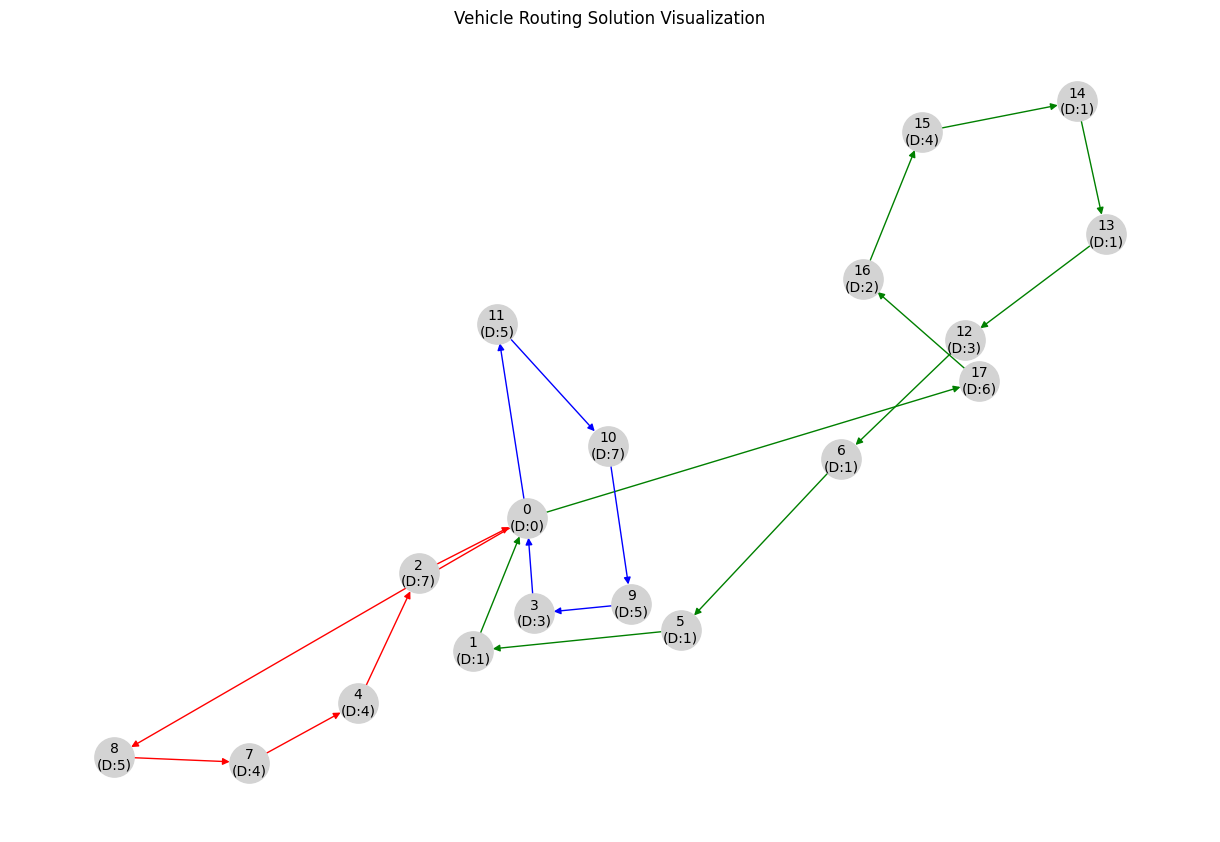

In [61]:
import matplotlib.pyplot as plt
import networkx as nx

# 데이터를 기반으로 생성된 경로 결과를 하드코딩
vehicle_routes = [
    [0, 8, 7, 4, 2, 0],  # Vehicle 0
    [0, 11, 10, 9, 3, 0],  # Vehicle 1
    [0, 17, 16, 15, 14, 13, 12, 6, 5, 1, 0],  # Vehicle 2
]

# 노드별 수요
demands = [0, 1, 7, 3, 4, 1, 1, 4, 5, 5, 7, 5, 3, 1, 1, 4, 2, 6]

# 시각화를 위한 색상 설정
colors = ["red", "blue", "green"]

# 그래프 생성
G = nx.DiGraph()

# 노드 추가 및 라벨링 (수요 포함)
for i, demand in enumerate(demands):
    G.add_node(i, demand=demand)

# 경로 추가 및 색상 부여
for vehicle_id, route in enumerate(vehicle_routes):
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], color=colors[vehicle_id])

# 엣지 색상 추출
edges = G.edges()
edge_colors = [G[u][v]["color"] for u, v in edges]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 그래프 시각화
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    # with_labels=True,
    edge_color=edge_colors,
    node_color="lightgrey",
    node_size=800,
)

# 노드에 수요 정보 추가
demand_labels = {node: f"{node}\n(D:{data['demand']})" for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=demand_labels, font_size=10)

plt.title("Vehicle Routing Solution Visualization")
plt.show()

로봇 수요량을 임의로 정해서 용량 제한 차량 배치함
- 테스트 상태(돌아가는 지만 확인함)
- 용량말고 시간이나 거리 제한이 가능한지 공부 후 수정 필요
- 용량과 총량은 랜덤으로 돌림
- 로봇 수 3대로 가정